# Logistic Regression Interpretation

This file contains 

1. findings and interpretations of the coefficient plots

2. boxplots to show the variation of coefficients as the model becomes more private 

3. barplots to show the how the ranking of the coefficients vary as the model becomes more private

# <a id="top">Jump to</a>

[Overall findings](#findings)

[Coefficient boxplots](#coefficients)

[Coefficient rankings](#rankings)

# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from tabulate import tabulate
import math

# Functions

In [2]:
# Function that takes in a dataframe
# and returns a dataframe of its summary statistics
def format_data(data):
    to_table = data.drop(data.columns[[0,-1]], axis=1) # drop intercept and eps
    to_table = to_table.describe().transpose().sort_values("mean")
    to_table = to_table.drop(to_table.columns[[0]], axis=1) # drop "count"
    to_table = to_table.reindex(to_table[["mean"]].abs().sort_values("mean", ascending=True).index) # sort by abs(mean)
    
    return(to_table)

In [3]:
# Function that prints a table
def print_table(table):
    print(tabulate(table, headers=table.columns.values, tablefmt='github'))

In [4]:
# Returns a list so that it contains all of df[col]'s values, grouped by epsilon
def get_col_values(df, col):
    box_vals = []
    eps = df.eps.unique()
    for ep in eps:
        box_vals.append(df[df.eps==ep][col])
    box_vals.reverse() # want epsilon decreasing
    
    return(box_vals)

In [5]:
# Creates a box plot with nrows and ncols
#   data_np: dataframe of nonprivate coefficients; to be used to plot a red line acting as baseline
#   box_vals: list of lists, each inner list containing the coefficient values for each epsilon
#   eps_str: list of eps as strings, to be used in xlabels
#   data_p: dataframe of everything
# Similar to 
# plot = data.boxplot(column=data.columns[0:len(data_p.columns)-1].tolist(), 
#                by='eps', rot=-40, grid=False, layout=(16,2), figsize=(10,70))
# The difference is that here, you have a line on each plot representing the nonprivate coef
def create_boxplots(data_p, data_np, nrows, ncols, ci = False):
    # Formatting x labels so that they are descending
    eps = data_p.eps.unique().tolist()
    eps_str = [str(math.log(ep,2)) for ep in eps] # for use in xlabels
    eps_str.reverse() # want epsilon decreasing in plot
    cols = data_p.columns[data_p.columns != "eps"]

    box_vals = [get_col_values(data_p, x) for x in cols]
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,50))

    z = 0 # to keep track of the next coefficient to plot

    # Plotting
    for i in range(nrows):
        for j in range(ncols):
            if z >= len(box_vals):
                break
                
            if ci:
                label_idx = coef_ci.coef[coef_ci.coef== box_vals[z][0].name].index[0] # index of intercept CI value
                ax[i,j].axhline(y=coef_ci.lower.values[label_idx], color = 'grey') # CI of normal logistic model
                ax[i,j].axhline(y=coef_ci.upper.values[label_idx], color = 'grey') # CI of normal logistic model

            
            ax[i,j].boxplot(box_vals[z])
            ax[i,j].axhline(y=data_np[box_vals[z][0].name].mean(), color = 'r') # non private model
            ax[i,j].set_xlabel("log_2(Epsilon)")
            ax[i,j].set_ylabel("Coefficient Value")
            ax[i,j].set_title(box_vals[z][0].name)
            ax[i,j].set_xticklabels(eps_str, rotation=30)
            ax[i,j].set_ylim(-4, 4)

            z = z + 1

    plt.tight_layout()
#     plt.savefig('coefficients_50runs.pdf')
    plt.show()

In [6]:
# Returns counts, labels
#   counts: list of lists where 
#      jth column corresponds with jth label
#      ith row corresponds with ith ranking (in reverse)
#      [i,j] is the number of times feature j appeared as rank i
#   labels: list of the labels where the jth label corresponds to the jth column in counts
def get_counts(df):
    # jth column corresponds with jth label
    # ith row corresponds with ith ranking (in reverse)
    ncols = len(df.transpose().index) - 1
    counts = [[0] * ncols for i in range(topN)]
    labels = [0] * ncols
    cols_used = len(labels) - 1 # keep track of how many unique features we've seen to update labels
    
    # How this works is that we transpose the df so that the columns are on the rows
    # then, we sort by each column, which will sort the column by abs value, 
    # reranking the row names, which are the features.
    # Once sorted, we get the topN row names and append that to labels as well as update counts appropriately
    transpose_df = df.drop(['eps'], axis = 1)
    transpose_df = transpose_df.transpose()
    
    # Go through each column and find top coefficients
    for i in transpose_df.columns:
        sorted_data = transpose_df.reindex(transpose_df[i].abs().sort_values(ascending=False).index) # sort by abs value of column i
        coefs = sorted_data.iloc[:, 1].index
        
        top_coef = [coefs[j] for j in range(topN)] # get topN coefficients

        # Update counts
        row = 0
        for coef in top_coef:
            if coef not in labels: # add labels
                labels[cols_used] = coef
                cols_used = cols_used - 1
            col = labels.index(coef)
#             print('coef:', coef, 'row:', row, 'col:', col)
            counts[row][col] = counts[row][col] + 1
            row = row + 1
    return counts, labels

In [7]:
# This function takes the counts and labels outputted by get_counts 
# and transforms it to only include data that will be plotted
# labels_to_use are the labels that we want to keep consistent on each plot -- typically this is 
# what the nonprivate model ranks as the most important
# If labels_to_use is blank, we assume that counts and labels corresponds to the nonprivate model
# so the labels we return are the labels_to_use
def transform_counts(counts, labels, labels_to_use=[]):
    # First, see how many features we need to cut down
    num_features = 0
    for i in range(len(labels)):
        if labels[i] != 0:
            num_features = num_features + 1
    
    # This is the nonprivate model and we need to find the labels_to_use
    if len(labels_to_use) == 0:
        # Cut down on the size of labels when there are many features we didn't get to see
        for i in range(len(counts)):
            counts[i] = counts[i][len(counts[i])-num_features:]
        labels = labels[len(labels)-num_features:]
        return counts, labels
        
        if num_features != topN:
            print("Implement me! -- Go to code")
            return
        
    else: # we have labels_to_use so we just find those labels and tally them up
        label_idxs = []
        for label in labels_to_use: # find labels
            idx = labels.index(label)
            label_idxs.append(idx)
            
        # Create new counts with the corresponding labels
        new_counts = [[0] * topN for i in range(topN)]
        
        # Go through counts and create the new counts
        for i in range(len(counts)):
            curr_rank = counts[i]
            for j in range(len(label_idxs)): # add each corresponding count to new_counts
                new_counts[i][j] = curr_rank[label_idxs[j]]
    
    return new_counts, labels_to_use

In [8]:
# Function that, for each epsilon, gets their counts and labels
# Returns:
#   counts_all: list of lists, where counts_all[i] is the ith epsilon
#      and counts_all[i][j][k] is the rank j counts of feature k, corresponding to labels_to_use[k]
def get_all_counts_labels(df):
    counts_all = []
    labels_to_use = []
    for ep in np.flip(df.eps.unique()): # inf NEEDS to come first
        data_ep = df[df['eps'] == ep]
        counts, labels = get_counts(data_ep)
        if ep == np.inf:
            counts, labels = transform_counts(counts, labels)
            labels_to_use = labels
        else:
            counts, labels = transform_counts(counts, labels, labels_to_use)
            
        counts_all.append(counts)
    return counts_all, labels_to_use

In [9]:
# Plots the rankings side by side
# Adapted from rankings plot for NN
def plot_rankings(df, counts, labels):
    eps_list = np.flip(df.eps.unique())

    # Set up plotting
    fig = plt.figure(figsize=(6*(len(eps_list)), 25),dpi=400)
    gs = plt.GridSpec(nrow,ncol)
    plt.subplots_adjust(right=.8)
    plt.figtext(.83, .54, 'Feature Color Legend', color='black', fontweight='bold', size=24)
    plt.figtext(.83, .52, 'Applicant Controlled Info', color='green', fontweight='bold')
    plt.figtext(.83, .50, 'Applicant Uncontrolled Info', color='blue', fontweight='bold')
    plt.figtext(.83, .48, 'Protected Classes', color='red', fontweight='bold')
    plt.figtext(.83, .46, 'Other', color='black', fontweight='bold')

    fig.patches.extend([plt.Rectangle((0.82,0.45),0.18,0.1,
                                      fill=False, color='black', alpha=1, zorder=1000,
                                      transform=fig.transFigure, figure=fig)])


    plots = []
    for row in range(ncol):
        plots.append([])
        for col in range(nrow):
            plots[row].append(fig.add_subplot(gs[col,row]))


    plt.subplots_adjust(wspace=.1)
    ind = np.arange(len(labels))
    width = .35

    # Iterate through all epsilon and plot
    row = 0
    col = 0
    eps_idx = 0
    for counts_ep in counts:
        pltdata = counts_ep
        for index in range(0,len(pltdata)):
            index = len(pltdata) - index - 1
            info = tuple(pltdata[index])
            offset = np.zeros(len(pltdata[0]))
            for x in range(index+1,len(pltdata)):
                for y in range(0, len(pltdata[x])):
                    offset[y] += pltdata[x][y]
            offset = tuple(offset)
            plots[col][row].barh(ind, info, width, left=offset, label=(index+1), color=colored_bars[index])

        if row == 0 and col == 0:
            plots[col][row].set_title('Epsilon: ' + 'Nonprivate', fontweight='bold', size=28)
        else:
            plots[col][row].set_title('Epsilon: ' + str(eps_list[eps_idx]), fontweight='bold', size=28)
        if col == 0:
            plots[col][row].set_yticks(ind)
            pltlabels = plots[col][row].set_yticklabels(labels)
            [i.set_color(colored_names[i.get_text()]) for i in pltlabels]
            new_labels = []
            for x in range(len(labels)):
                new_labels.append(renamed_features[labels[x]])
            pltlabels = plots[col][row].set_yticklabels(new_labels)

        else:
            plots[col][row].set_yticks([])
        handles, new_labels = plots[col][row].get_legend_handles_labels()
        if row == len(plots) - 1:
            plots[col][row].legend(handles[::-1], new_labels[::-1], title='Rank', loc='center left', bbox_to_anchor=(1, 0.5))
        plots[col][row].set_xlabel('# of times ranked top ' + str(topN) + ' feature')

        # Update next plot to plot
        col = col+1
        if col == ncol:
            col = 0
            row = row + 1
            if row == nrow:
                row = 0

        eps_idx = eps_idx + 1


    plt.savefig('all_model_valued_features' + '.pdf', bbox_inches='tight')
    plt.show()

# Reading in data

In [10]:
data_balance_action_large_reg = pd.read_csv('./output/no onehot and fixed kfold/coef_50runs_357160rows_balance_action_default_reg.csv')
data_balance_action_race_large_reg = pd.read_csv('./output/no onehot and fixed kfold/coef_50runs_209040rows_balance_action_race_default_reg.csv')
data_balance_action_sub = pd.read_csv('./output/no onehot and fixed kfold/coef_25runs_35716rows_balance_action_subset.csv')

# <a id='findings'>Findings</a>

1. **As the model becomes more private, the variation of coefficients *increases*.**
    
    a. From all of the [boxplots](#boxplots), you can observe this happening.
    
    b. This is expected since the noise added to the models increase as epsilon decreases.



2. **Compared to using the full dataset, using a smaller subset of the data in the model results in *larger* variation in coefficients and coefficient values.**

    a. For example, in the [full dataset](#boxplots), looking at the boxplot for tract_to_msamd_income shows that at the largest amount of privacy, the maximum the coefficient value reaches is 1.41, and the minimum is -0.03. 

    b. On the other hand, in the [subsetted dataset](#subset), the boxplot for tract_to_msamd_income shows that at the largest amount of privacy, the maximum the coefficient value reaches is 8.39, and the minimum is -4.51. 

    c. This could explain why you see larger changes in AUC and disparate imapact when using a subset of the dataset.


3. **Balancing by acceptances, denials, and race *decreases* the median coefficient for applicant race (from 2 to -0.5)**

    a. This could be why the model trained on this dataset is [more fair](#adr) than the model trained on only balanced acceptances and denials.


4. **As the model becomes more private, the models tend to have the *same* top 7 rankings.**

    a. This could explain why the AUC and disparate impact is [relatively unchanging](#rankings) for smaller epsilon.

[Back to top](#top)

# <a id="coefficients"> Create boxplots for each coefficient </a>

From all the plots, we see that variance increases as epsilon decreases. They are also generally centered around the true value.

In [14]:
ncols = 2

### <a id="boxplots"> Balanced acceptances and denials </a>

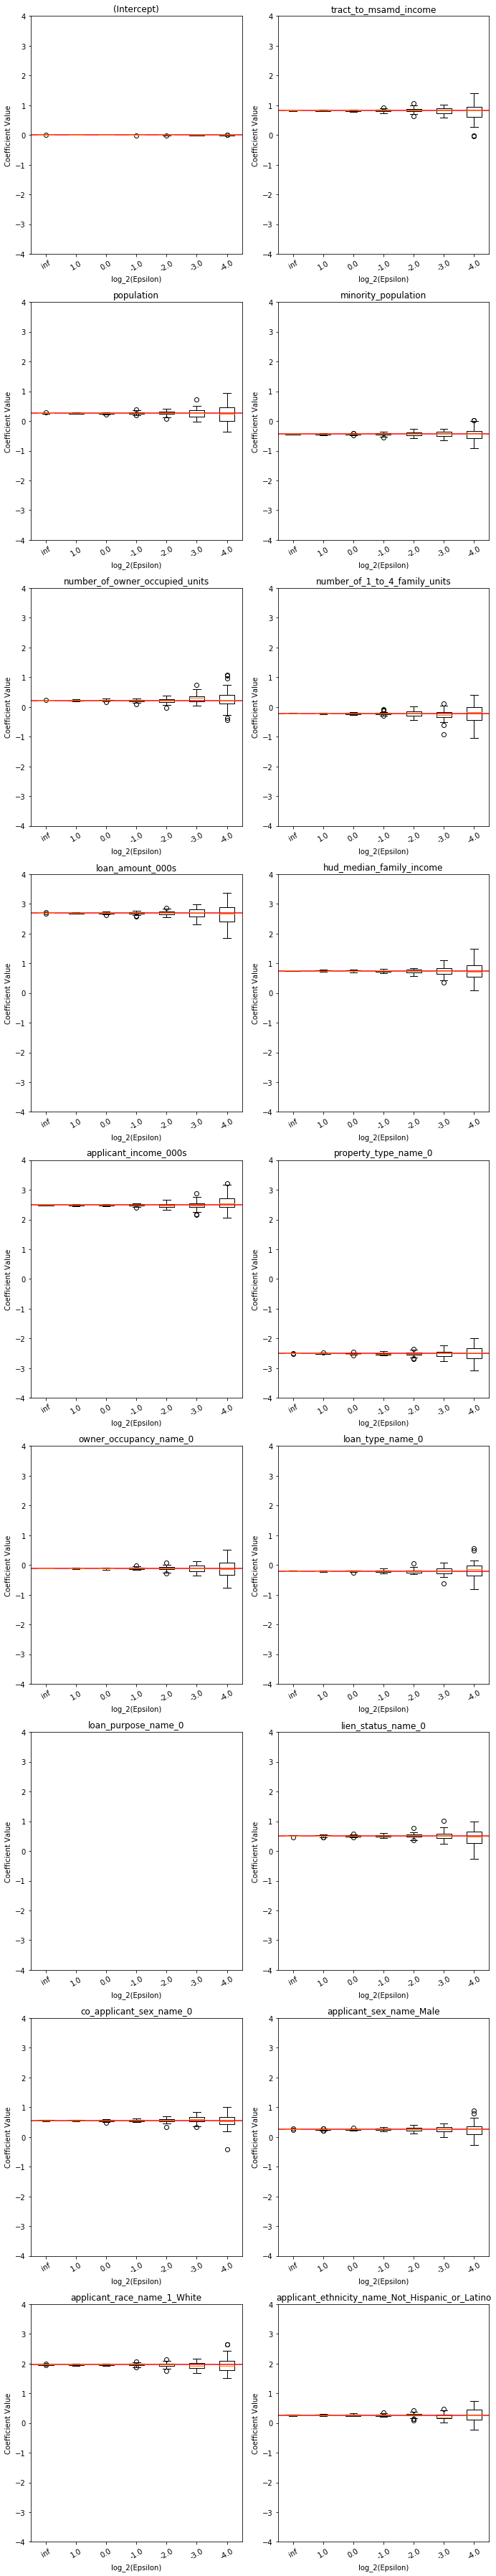

In [17]:
nrows = math.ceil(int((data_balance_action_large_reg.shape[1] - 1)/2))

create_boxplots(data_p=data_balance_action_large_reg, 
                data_np=data_balance_action_large_reg[data_balance_action_large_reg.eps == np.inf], 
                nrows=nrows, ncols=ncols)

[Back to top](#top)

### <a id ="subset"> Balanced acceptances and denials, subset </a>

Compared to using the full dataset, using a smaller subset of the data (10% of the full data = 35716 rows) in the model results in larger variation in coefficients and coefficient values.

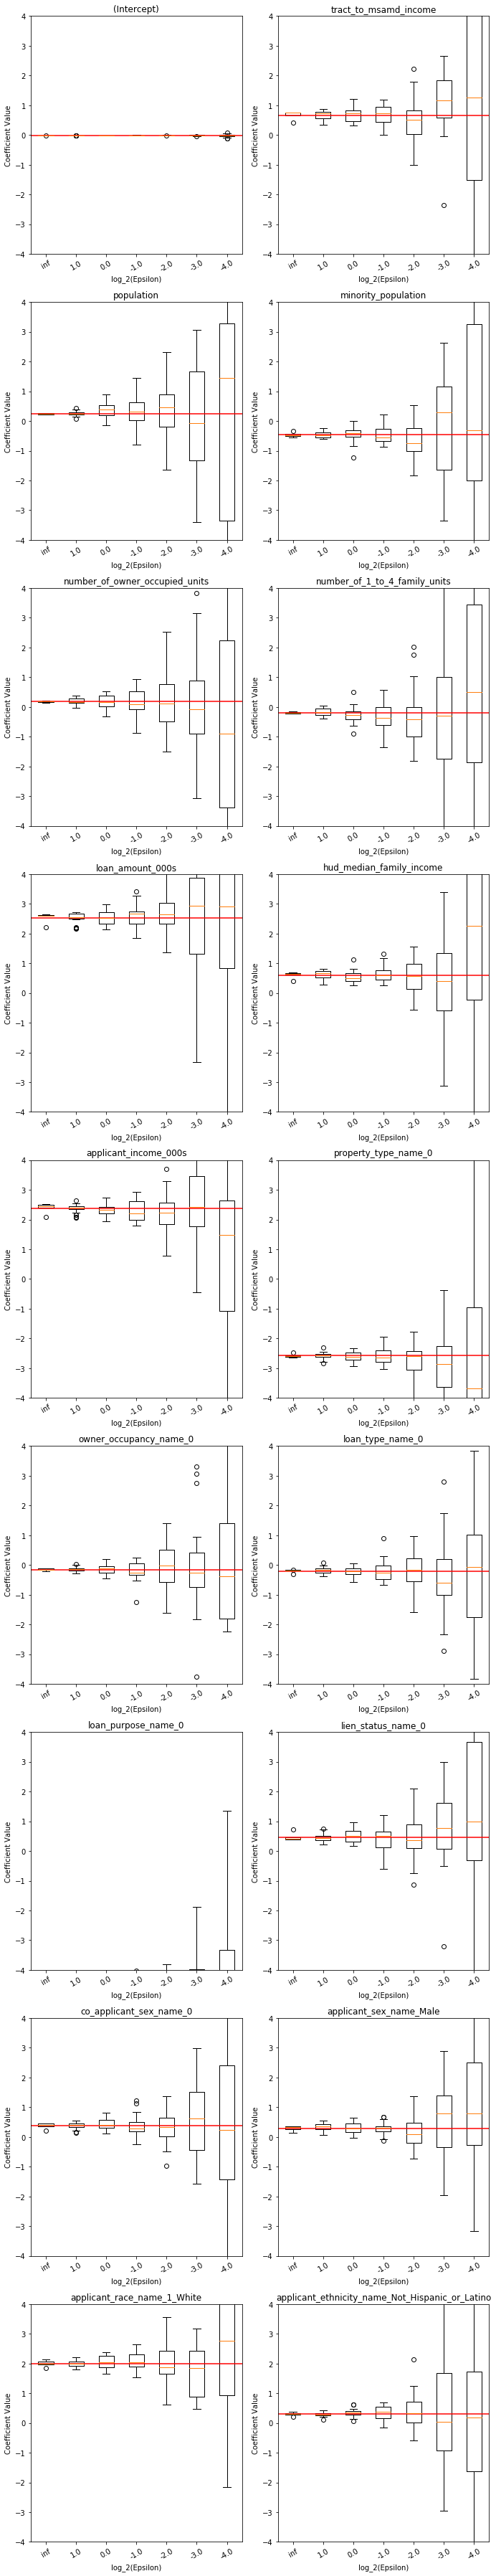

In [22]:
nrows = math.ceil(int((data_balance_action_sub.shape[1] - 1)/2))

create_boxplots(data_p=data_balance_action_sub, 
                data_np=data_balance_action_sub[data_balance_action_sub.eps == np.inf], 
                nrows=nrows, ncols=ncols)

[Back to top](#top)

### <a id="adr"> Balanced acceptances, denials, and race </a>

Balancing by acceptances, denials, and race decreases the median coefficient for applicant race compared to the coefficient from the model run on balanced acceptances and denials (from 2 to -0.5)

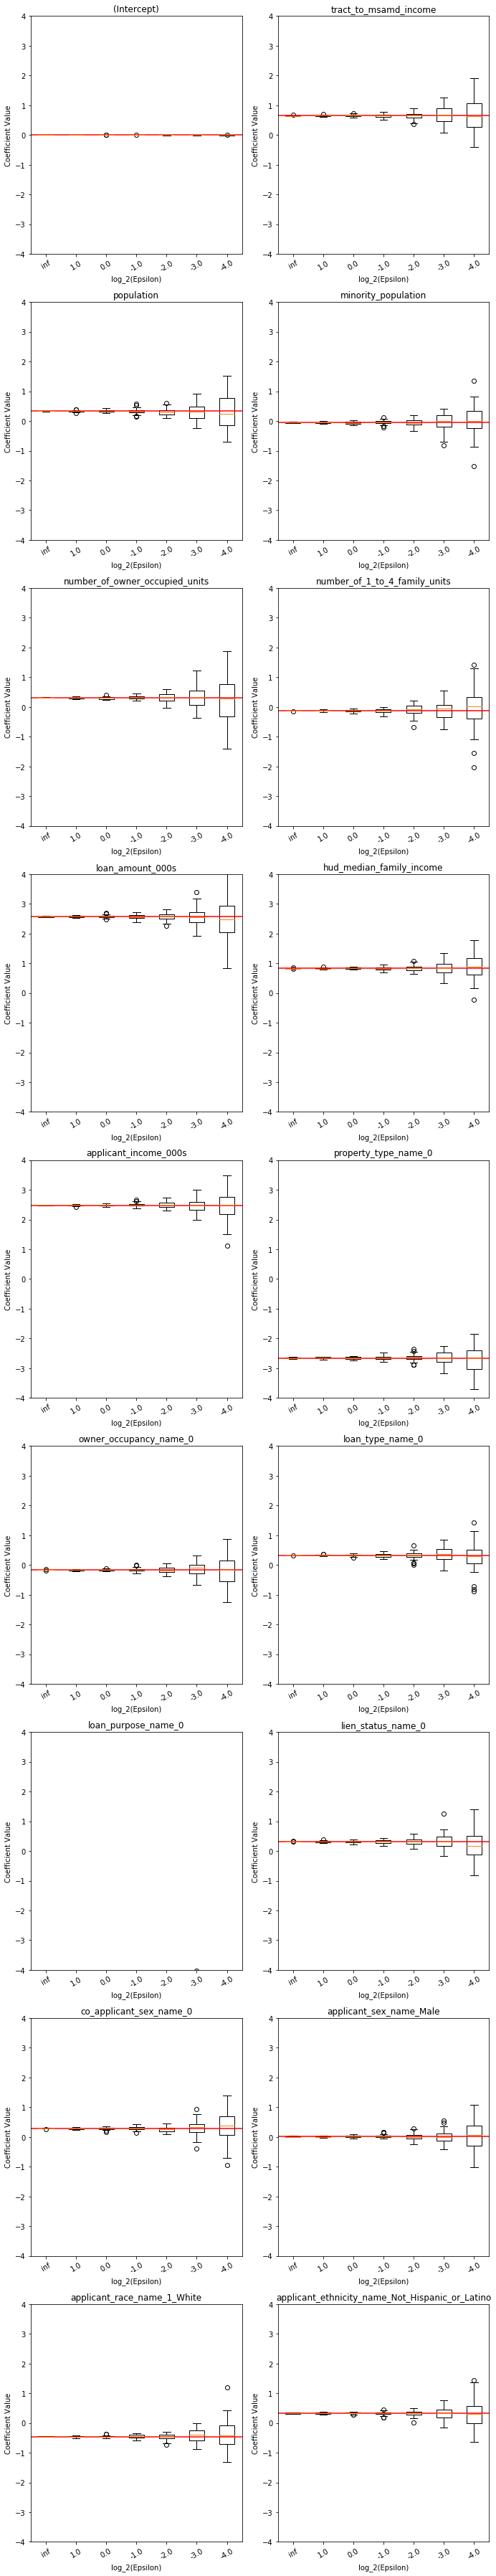

In [18]:
nrows = math.ceil(int((data_balance_action_race_large_reg.shape[1] - 1)/2))

create_boxplots(data_p=data_balance_action_race_large_reg, 
                data_np=data_balance_action_race_large_reg[data_balance_action_race_large_reg.eps == np.inf], 
                nrows=nrows, ncols=ncols)

[Back to top](#top)

# Rankings

In [19]:
topN = 9
ncol = 3
nrow = 3

colored_names = {
    '(Intercept)' : 'black',
    'tract_to_msamd_income' : 'black',
    'population' : 'black',
    'minority_population' : 'black',
    'number_of_owner_occupied_units' : 'black',
    'number_of_1_to_4_family_units' : 'black' ,
    'loan_amount_000s' : 'green',
    'hud_median_family_income' : 'black',
    'applicant_income_000s' : 'green',
    'property_type_name_0' : 'green',
    'owner_occupancy_name_0' : 'green',
    'loan_type_name_0' : 'green',
    'loan_purpose_name_0' : 'green',
    'lien_status_name_0' : 'green',
    'co_applicant_sex_name_0' : 'green',
    'applicant_sex_name_Male' : 'red',
    'applicant_race_name_1_White' : 'red',
    'applicant_ethnicity_name_Not_Hispanic_or_Latino' : 'red',
    'agency_abbr_0' : 'black'
}

renamed_features = {
    'tract_to_msamd_income' : 'Tract Income Ratio',
    'population' : 'Population',
    'minority_population' : 'Tract % Minority',
    'number_of_owner_occupied_units' : 'Tract # Owners',
    'number_of_1_to_4_family_units' : 'Tract # Families' ,
    'loan_amount_000s' : 'Loan Amount',
    'hud_median_family_income' : 'Tract Income',
    'applicant_income_000s' : 'App. Income',
    'property_type_name_0' : 'Property Type',
    'owner_occupancy_name_0' : 'Owner Occupancy',
    'loan_type_name_0' : 'Loan Type',
    'loan_purpose_name_0' : 'Loan Purpose',
    'lien_status_name_0' : 'Lien Status',
    'co_applicant_sex_name_0' : 'Has Co-app',
    'applicant_sex_name_Male' : 'App. Sex',
    'applicant_race_name_1_White' : 'App. Race',
    'applicant_ethnicity_name_Not_Hispanic_or_Latino' : 'App. Ethnicity',
    'agency_abbr_0' : 'Agency'
}
colored_bars = [
#     (208/255,209/255,230/255), # for topN = 5
#     (166/255,189/255,219/255),
#     (116/255,169/255,207/255),
#     (43/255,140/255,190/255),
#     (4/255,90/255,141/255)
    
    (255/255,247/255,251/255), # for topN = 9
    (236/255,231/255,242/255),
    (208/255,209/255,230/255),
    (166/255,189/255,219/255),
    (116/255,169/255,207/255),
    (54/255,144/255,192/255),
    (5/255,112/255,176/255),
    (4/255,90/255,141/255),
    (2/255,56/255,88/255)
]
colored_bars.reverse()

## <a id="rankings"> Rankings Plots </a>

As the model becomes more private, the models tend to have the same top 9 rankings, in the same ordering.

In [46]:
counts, labels = get_all_counts_labels(data_balance_action_large_reg)
plot_rankings(data_balance_action_large_reg, counts, labels)

[Back to top](#top)